In [1]:
import itertools
import logging
import math
import textwrap
import qiskit
import pandas as pd
from qiskit import Aer
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit.circuit.add_control import add_control
from qiskit.compiler import transpile
from qiskit.extensions import *
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from string_comparison import StringComparator

logger = logging.getLogger(__name__)


## Measure only the register c and then db id register


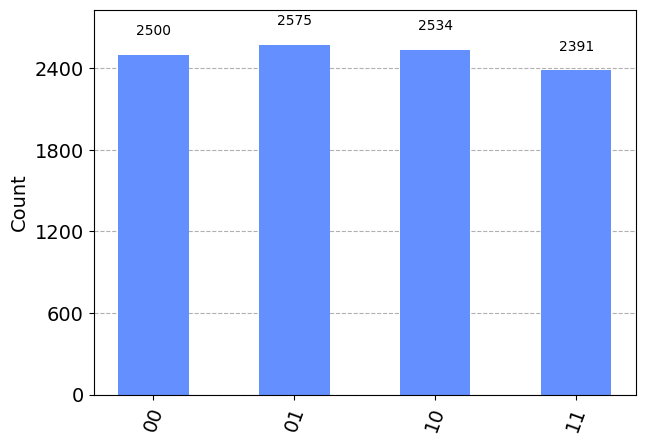

In [48]:
u_register_len = 2
input_size = 2
symbol_length = 1
db_id_len = 1
size_of_single_ham_register = math.floor(input_size / symbol_length)

t = 1

memory_register = QuantumRegister(input_size)
u_register = QuantumRegister(u_register_len)
single_ham_dist_register = QuantumRegister(size_of_single_ham_register)
db_id_register = QuantumRegister(db_id_len)

qubits_range = db_id_len + u_register_len 
classic_register = ClassicalRegister(1 + db_id_len)
circuit = QuantumCircuit( u_register, db_id_register, memory_register, single_ham_dist_register, classic_register)



def _copy_pattern_to_memory_register(my_string, i=1):
    for j in range(len(my_string)):
        if my_string[j] == "1":
            circuit.cx(u_register[i], memory_register[j])
        else:
            circuit.x(memory_register[j])

def copy_db_id_to_db_id_register(log_id, i=1):
    for j in range(len(log_id)):
        if log_id[j] == "1":
            circuit.cx(u_register[i], db_id_register[j])
        else:
            circuit.x(db_id_register[j])
        
def store_db_and_db_ids(logs):
    circuit.x(u_register[1])
    for my_reg in range(size_of_single_ham_register):
        circuit.x(single_ham_dist_register[my_reg])
        
    for ind in range(len(logs)):
        log, log_id = logs[ind]
        
        _copy_pattern_to_memory_register(log)

        copy_db_id_to_db_id_register(log_id)
        
        circuit.mct(list(range(2, 2 + db_id_len + input_size)), u_register[0])
    
        _x = len(logs) + 1 - (ind + 1)
        cs = Operator([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, math.sqrt((_x - 1) / _x), 1 / (math.sqrt(_x))],
            [0, 0, -1 / (math.sqrt(_x)), math.sqrt((_x - 1) / _x)]
        ])
        circuit.unitary(cs, [1, 0], label='cs')

        circuit.mct(list(range(2, 2 + db_id_len + input_size)), u_register[0])
        _copy_pattern_to_memory_register(log)
        
        copy_db_id_to_db_id_register(log_id)
    

def _fill_ones_in_memory_register_which_are_equal_to_bits_in_pattern( my_string):
    for j in range(input_size):
        if my_string[j] == "0":
            circuit.x(memory_register[j])
        
def _compare_input_and_pattern_for_single_ham_register(i):
    for j in range(size_of_single_ham_register):
        idx = symbol_length * j
        temp = []
        for ind in range(idx, idx + symbol_length):
            temp.append(ind + i)
        circuit.mct(temp, single_ham_dist_register[j])

def retrieve_info(input_string, register_u=1):
        circuit.h(register_u)
        _fill_ones_in_memory_register_which_are_equal_to_bits_in_pattern(input_string)

        _compare_input_and_pattern_for_single_ham_register(register_u + db_id_len + 1)
        u_gate = Operator([
            [math.e ** (complex(0, 1) * math.pi / (2 * ((input_size / symbol_length) * t))), 0],
            [0, 1]
        ])
        for ind in range(size_of_single_ham_register):
            circuit.unitary(u_gate, single_ham_dist_register[ind], label='U')
        u_minus_2_gate = Operator([
            [1 / math.e ** (complex(0, 1) * math.pi / ((input_size / symbol_length) * t)), 0],
            [0, 1]
        ])
        gate2x2 = UnitaryGate(u_minus_2_gate)
        gate2x2_ctrl = add_control(gate2x2, 1, 'CU2x2', '1')
        for j in range(size_of_single_ham_register):
            circuit.append(gate2x2_ctrl, [1, single_ham_dist_register[j]])

        # Reverse previous operations using mid circuit measurement: https://www.youtube.com/watch?v=w951uiUBntw&t=42s
        _compare_input_and_pattern_for_single_ham_register(register_u+db_id_len+1)
        _fill_ones_in_memory_register_which_are_equal_to_bits_in_pattern(input_string)

        circuit.h(1)
        
        circuit.measure(u_register[1], 0)
        
logs = [["11", "0"], ["00", "0"],["01", "1"],["10", "1"]]
store_db_and_db_ids(logs)
retrieve_info("01")
circuit.measure(range(2, 2 + db_id_len), 
                range(1, 1 + db_id_len))
quantum_instance = Aer.get_backend('qasm_simulator')
shots = 10000
job = execute(circuit, quantum_instance, shots=shots)
results_raw = job.result().get_counts(circuit)
results_raw
results_cleaned = {}
for res in results_raw:
    results_cleaned[res[::-1]] = results_raw[res]
results_cleaned

from qiskit.visualization import plot_histogram
plot_histogram(results_cleaned)